https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

# Jak przewidzieć wiele szeregów czasowych jednocześnie za pomocą Scikit-Learn (z przykładem prognozowania sprzedaży)

Masz wiele punktów danych szeregów czasowych i chcesz przewidzieć następny krok (lub kroki). Co powinieneś teraz zrobić? Wytrenuj model dla każdej serii? Czy jest sposób na dopasowanie modelu do wszystkich serii razem? Co jest lepsze?

Widziałem wielu analityków danych, którzy zastanawiali się nad podejściem do tego problemu, tworząc jeden model dla każdego produktu. Chociaż jest to jedno z możliwych rozwiązań, prawdopodobnie nie będzie najlepsze.

W tym miejscu pokażę, jak wytrenować pojedynczy model do prognozowania wielu szeregów czasowych w tym samym czasie. Ta technika zwykle tworzy potężne modele, które pomagają zespołom wygrywać konkursy na uczenie maszynowe i można je wykorzystać w projekcie.

I nie potrzebujesz do tego modeli głębokiego uczenia!

# Indywidualne modele uczenia maszynowego a duży model dla wszystkiego

W uczeniu maszynowym więcej danych zwykle oznacza lepsze prognozy. Jeśli spróbujesz stworzyć jeden model dla każdej serii, będziesz miał pewne problemy z seriami, które zawierają niewiele danych lub nie zawierają ich wcale.

Gdy łączysz wszystkie serie w jeden zestaw danych, aby wytrenować jeden model, używasz znacznie więcej danych. Może to pomóc modelowi lepiej działać!

Biorąc pod uwagę więcej niż jedną serię na raz, algorytmy uczenia maszynowego będą w stanie nauczyć się bardziej subtelnych wzorców, które powtarzają się w różnych seriach. Produkt staje się zmienną w naszym modelu.

Najpierw zaimportujmy nasze podstawowe narzędzia:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Przygotowanie danych
Dane zostały pozyskane z Repozytorium UCI.

Tutaj postaramy się prognozować sprzedaż dla 811 produktów. Nasz zbiór danych zawiera rekordy sprzedaży z 52 tygodni dla każdego z produktów.

Oznacza to, że pierwotnie mamy 811 szeregów czasowych z 52 punktami danych każdy. Tutaj biorę tylko kod produktu i nieznormalizowaną tygodniową sprzedaż dla każdego produktu.

Tak wyglądają dane:

In [2]:
cols = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv", nrows=1).columns
df = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv", usecols=cols[:53])
df.tail()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0
810,P819,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
df.shape

(811, 53)

W tym momencie wielu analityków danych próbowałoby dopasować model do każdego produktu. I chociaż może to działać dobrze, możemy mieć problemy z powodu posiadania tylko 52 punktów danych dla każdego modelu, co jest naprawdę niskie!

Ponieważ modele uczenia maszynowego mają tendencję do ulepszania się przy większej ilości danych, dlaczego nie spróbować połączyć wszystkich serii i wytrenować jednego modelu z większą ilością danych?

Aby to zrobić, musimy „stopić” dane. Oznacza to po prostu przekształcenie danych w taki sposób, w jaki każda linia staje się: kodem produktu, tygodniem, sprzedażą

Aby ułatwić nam życie, postanowiłem usunąć litery z kodu produktu i tygodnia.

In [4]:
df2 = df.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
df2

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


### Likwidacja liter W i P

In [5]:
df2.Product_Code = df2.Product_Code.str.replace('P', '').astype(int)
df2.Week = df2.Week.str.replace('W', '').astype(int)
df2

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0


In [6]:
df2.dtypes

Product_Code    int64
Week            int64
Sales           int64
dtype: object

max: 73
min: 0


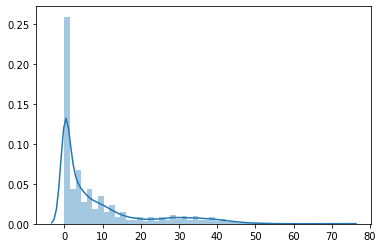

In [7]:
print('max:',df2['Sales'].max())
print('min:',df2['Sales'].min())

sns.distplot(np.array(df2['Sales']))

In [8]:
df2.shape

(42172, 3)

In [9]:
df2['Sales_last_1_week'] = df2.groupby(['Product_Code'])['Sales'].shift()
df2['Sales_last_2_week'] = df2.groupby(['Product_Code'])['Sales'].shift(2)
df2['Sales_last_3_week'] = df2.groupby(['Product_Code'])['Sales'].shift(3)
df2['Sales_last_4_week'] = df2.groupby(['Product_Code'])['Sales'].shift(4)
df2

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week
0,1,0,11,NaN,NaN,NaN,NaN
1,2,0,7,NaN,NaN,NaN,NaN
2,3,0,7,NaN,NaN,NaN,NaN
3,4,0,12,NaN,NaN,NaN,NaN
4,5,0,8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
42167,815,51,0,2.0,0.0,0.0,1.0
42168,816,51,5,6.0,5.0,5.0,5.0
42169,817,51,3,4.0,0.0,0.0,0.0
42170,818,51,0,2.0,0.0,0.0,0.0


Sprawdzenie przesunięcia

In [10]:
df2[df2.Week.isin([7,8,9,10,11,12,13])&(df2.Product_Code ==2)][['Product_Code',
                                                                'Sales',
                                                                'Sales_last_1_week',
                                                                'Sales_last_2_week',
                                                                'Sales_last_3_week',
                                                                'Sales_last_4_week']] 


,Product_Code,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week
5678,2,3,6.0,1.0,7.0,2.0
6489,2,3,3.0,6.0,1.0,7.0
7300,2,3,3.0,3.0,6.0,1.0
8111,2,2,3.0,3.0,3.0,6.0
8922,2,2,2.0,3.0,3.0,3.0
9733,2,6,2.0,2.0,3.0,3.0
10544,2,2,6.0,2.0,2.0,3.0


In [11]:
df2['Diff_sales_last_1_week'] = df2.groupby(['Product_Code'])['Sales_last_1_week'].diff()
df2['Diff_sales_last_2_week'] = df2.groupby(['Product_Code'])['Sales_last_2_week'].diff()
df2['Diff_sales_last_3_week'] = df2.groupby(['Product_Code'])['Sales_last_3_week'].diff()
df2['Diff_sales_last_4_week'] = df2.groupby(['Product_Code'])['Sales_last_4_week'].diff()

# Sprawdzenie diff

In [12]:
df2[df2.Week.isin([7,8,9,10,11,12,13])&(df2.Product_Code ==4)][['Product_Code',
                                                                'Sales',
                                                                'Sales_last_1_week',
                                                                'Diff_sales_last_1_week',
                                                                'Sales_last_4_week',
                                                                'Diff_sales_last_4_week']]  

,Product_Code,Sales,Sales_last_1_week,Diff_sales_last_1_week,Sales_last_4_week,Diff_sales_last_4_week
5680,4,13,9.0,3.0,5.0,-8.0
6491,4,13,13.0,4.0,9.0,4.0
7302,4,11,13.0,0.0,6.0,-3.0
8113,4,8,11.0,-2.0,9.0,3.0
8924,4,4,8.0,-3.0,13.0,4.0
9735,4,5,4.0,-4.0,13.0,0.0
10546,4,4,5.0,1.0,11.0,-2.0


In [13]:
print('Before dropna:',df2.shape)
df2 = df2.dropna(how ='any')
print('After dropna: ',df2.shape)

Before dropna: (42172, 11)
After dropna:  (38117, 11)


In [17]:
df2.head(3)

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week
4055,1,5,12,13.0,8.0,10.0,12.0,5.0,-2.0,-2.0,1.0
4056,2,5,1,7.0,2.0,3.0,6.0,5.0,-1.0,-3.0,-1.0
4057,3,5,8,10.0,9.0,8.0,11.0,1.0,1.0,-3.0,4.0


In [18]:
for week in range(36,42):
    train = df2[df2['Week'] < week]   ## okres treningowy do 36 tygodnia
    val = df2[df2['Week'] == week]    ## okres testowy od 36 tygodnia włącznie do 42 tygodnia 
                                        ## 43-52 tydzień to okres super testowy

    Xtrain, Xtest = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)  # podział na zmienne treningowe i testowe
    ytrain, ytest = train['Sales'].values, val['Sales'].values                  # podział na wyniki testowe i treningowe 

In [19]:
# kolorowe wydruki
class colors:
           
    def green(self,text):
           print('\033[32m', text, '\033[0m', sep='') 

    def blue(self,text):
         print('\033[34m', text, '\033[0m', sep='')

    def magenta(self,text):
         print('\033[35m', text, '\033[0m', sep='')  

    def cyan(self,text):
         print('\033[36m', text, '\033[0m', sep='')

    def red(self,text):
         print('\033[31m', text, '\033[0m', sep='')  

    def yellow(self,text):
         print('\033[33m', text, '\033[0m', sep='')  
pass

CO = colors()

<span style="font-size: 180%;color:#1155cc">Uruchamiam paczkę modeli regresji

<span style="font-size: 110%;color:#1155cc">Celem jest wybranie najlepszego modelu.

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import warnings   
warnings.filterwarnings("ignore")

modele = [KNeighborsRegressor(),
          DecisionTreeRegressor(),
          BaggingRegressor(),
          GradientBoostingRegressor(),
          LinearRegression(),
          AdaBoostRegressor(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          ExtraTreesRegressor(),
          RandomForestRegressor(),
          #SVR()
          ] 

nazwy = ['K-Neighbors Regressor',
          'Decision Tree Regressor',
          'Bagging Regressor',
          'Gradient Boosting Regressor',
          'Linear Regression',
          'AdaBoost Regressor',
          'Ridge',
          'Huber Regressor',
          'Elastic Net CV',
          'ExtraTreesRegressor',
          'Random Forest Regressor',
          #'Support Vector Regression'
          ]

In [21]:
def model_val(t):
    
    global mean_dev,r2
    
    kfold = model_selection.KFold(n_splits=12, random_state=148)
    mean_dev = model_selection.cross_val_score(t, Xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_error')
    mean_dev = np.round(mean_dev, decimals=1)
    r2 = model_selection.cross_val_score(t, Xtrain, ytrain, cv=kfold, scoring='r2')
    r2 = np.round(r2, decimals=2)
    
    return mean_dev,r2


K-Neighbors Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.91 0.92 0.91 0.91 0.91 0.83 0.78 0.88 0.89 0.9  0.89]
Mean_dev:  [-2.4 -2.4 -2.3 -2.4 -2.4 -2.4 -3.  -2.8 -2.2 -2.2 -2.2 -2.2]


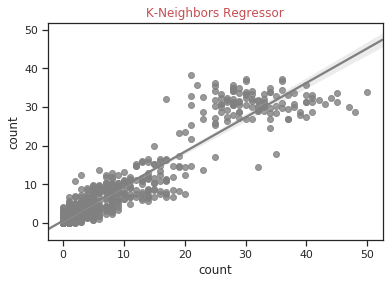

time: 3.0 seconds


Decision Tree Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.83 0.85 0.85 0.85 0.83 0.85 0.76 0.66 0.79 0.81 0.81 0.81]
Mean_dev:  [-3.2 -3.1 -3.1 -3.2 -3.2 -3.  -3.5 -3.5 -2.9 -2.9 -2.9 -2.9]


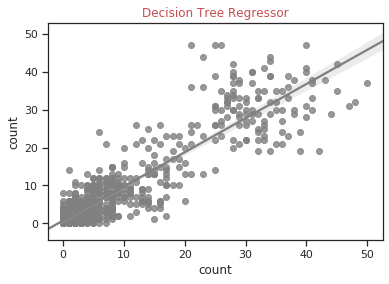

time: 4.0 seconds


Bagging Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.92 0.92 0.91 0.91 0.92 0.86 0.78 0.88 0.89 0.9  0.9 ]
Mean_dev:  [-2.4 -2.4 -2.3 -2.4 -2.4 -2.3 -2.7 -2.8 -2.1 -2.1 -2.2 -2.2]


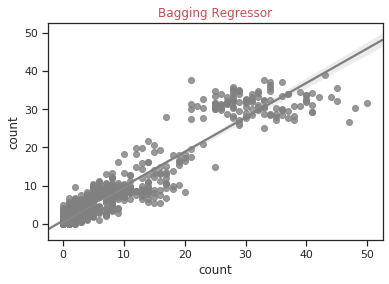

time: 22.0 seconds


Gradient Boosting Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.93 0.93 0.92 0.92 0.92 0.87 0.82 0.89 0.91 0.91 0.91]
Mean_dev:  [-2.3 -2.2 -2.2 -2.3 -2.3 -2.2 -2.6 -2.6 -2.1 -2.  -2.1 -2.1]


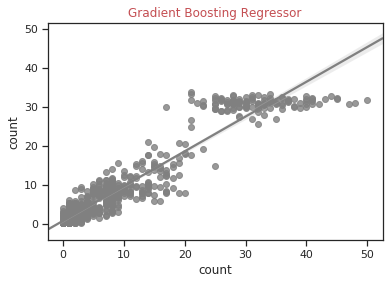

time: 54.0 seconds


Linear Regression
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.92 0.92 0.92 0.86 0.79 0.88 0.9  0.9  0.91]
Mean_dev:  [-2.3 -2.2 -2.2 -2.4 -2.3 -2.3 -2.7 -2.8 -2.2 -2.1 -2.1 -2.1]


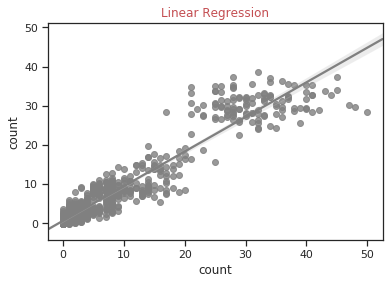

time: 1.0 seconds


AdaBoost Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.88 0.9  0.89 0.9  0.89 0.89 0.84 0.71 0.83 0.87 0.86 0.87]
Mean_dev:  [-4.1 -3.6 -3.6 -3.8 -3.7 -3.6 -3.3 -4.1 -3.5 -3.2 -3.2 -3.3]


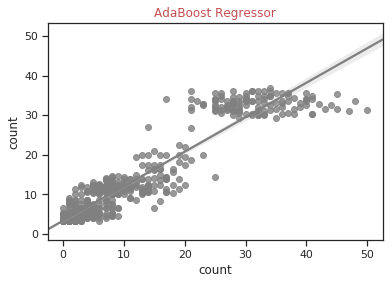

time: 34.0 seconds


Ridge
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.92 0.92 0.92 0.86 0.79 0.88 0.9  0.9  0.91]
Mean_dev:  [-2.3 -2.2 -2.2 -2.4 -2.3 -2.3 -2.7 -2.8 -2.2 -2.1 -2.1 -2.1]


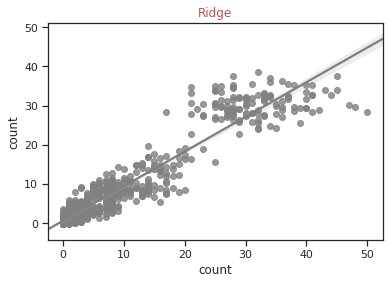

time: 1.0 seconds


Huber Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.92 0.92 0.92 0.86 0.8  0.88 0.9  0.9  0.91]
Mean_dev:  [-2.3 -2.2 -2.2 -2.3 -2.3 -2.2 -2.7 -2.7 -2.2 -2.1 -2.1 -2.1]


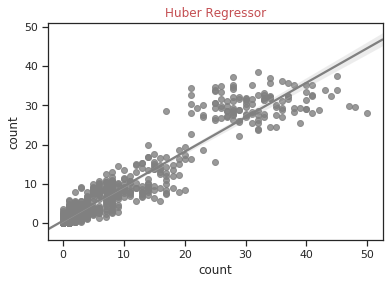

time: 10.0 seconds


Elastic Net CV
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.92 0.92 0.92 0.91 0.92 0.86 0.79 0.88 0.9  0.9  0.91]
Mean_dev:  [-2.3 -2.3 -2.3 -2.4 -2.4 -2.3 -2.7 -2.8 -2.2 -2.1 -2.1 -2.1]


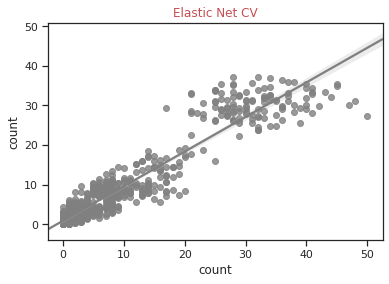

time: 10.0 seconds


ExtraTreesRegressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.92 0.91 0.92 0.87 0.8  0.89 0.9  0.9  0.91]
Mean_dev:  [-2.3 -2.3 -2.2 -2.3 -2.4 -2.3 -2.6 -2.8 -2.1 -2.1 -2.1 -2.1]


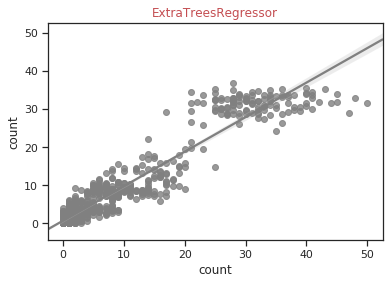

time: 118.0 seconds


Random Forest Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.92 0.92 0.93 0.87 0.81 0.89 0.9  0.91 0.91]
Mean_dev:  [-2.3 -2.2 -2.2 -2.3 -2.3 -2.2 -2.6 -2.7 -2.1 -2.  -2.1 -2.1]


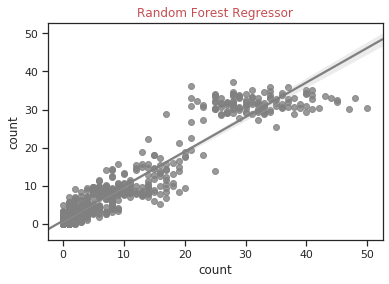

time: 188.0 seconds



In [22]:
for n,p in zip(nazwy,modele):      
    
    import matplotlib.pyplot as plt
    import time   
    
    start_time = time.time()
    
    results = model_val(p)
    print()
    CO.red(n)
    print("-------------------------------cross_val, KFold = 12 ------")
    print('R2: ', r2)
    print('Mean_dev: ', mean_dev)
    
    # wykres 
    plt.rc("font",size=14)
    clf = p
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xtest)

    ax = sns.regplot(ytest,ypred,color='grey')
    plt.title(n,color='r') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()
    
    # pomiar czasu
    n = (time.time() - start_time)
    n = np.round(n)
    CO.cyan('time: %s seconds' % n)    
    print()

 <span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja Linear Regression</span> <span style="font-size: 150%;color:white;background:RED"> 4 sekundy

Linear Regression: 0.8981180117605012
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
LinearRegression(fit_intercept=False, normalize=True)


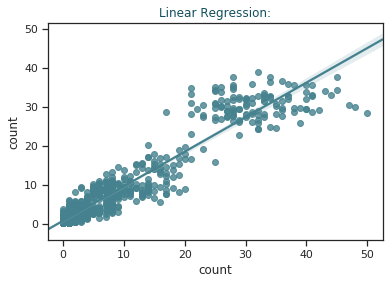

time: 1.0 seconds


In [23]:
#from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import time   
    
start_time = time.time()


parameters = [{'fit_intercept': [True, False], 'normalize': [True, False],'copy_X': [True, False]}]



Linear_Regression = GridSearchCV(LinearRegression(), parameters)
Linear_Regression.fit(Xtrain,ytrain)


print('Linear Regression:',Linear_Regression.best_score_)
print(Linear_Regression.best_params_)
print(Linear_Regression.best_estimator_)

    # wykres
    
plt.rc("font",size=14)
Linear_Regression.fit(Xtrain,ytrain)
ypred = Linear_Regression.predict(Xtest)

ax = sns.regplot(ytest,ypred,color='#45818e')
plt.title('Linear Regression:',color='#134f5c') 
plt.ylabel('count', fontsize=12) 
plt.xlabel('count', fontsize=12) 
plt.show()


# pomiar czasu
n = (time.time() - start_time)
n = np.round(n)
print('time: %s seconds' % n)  

<span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja 'Random Forest Regressor'</span> <span style="font-size: 150%;color:white;background:RED"> 249 sekund 

 <span style="font-size: 150%;color:white;background:#1155cc">  GradientBoostingRegressor</span> <span style="font-size: 150%;color:white;background:RED"> 239 sekund

<span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja 'Extra Trees Regressor'</span> <span style="font-size: 150%;color:white;background:RED"> 4 sekundy 

<span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja 'ElasticNetCV()'</span> <span style="font-size: 150%;color:white;background:RED"> 417 sekund 

Elastic NetCV: 0.8981280024764124
{'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 500, 'n_alphas': 50, 'normalize': True}
ElasticNetCV(l1_ratio=1, max_iter=500, n_alphas=50, normalize=True)


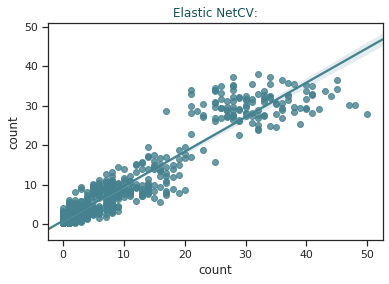

time: 408.0 seconds


In [24]:
#from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNetCV
import time   
    
start_time = time.time()


parameters = [{
 'l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
 'n_alphas' : [50, 100, 150],
 'fit_intercept': [True, False],
 'normalize': [True, False],
 'max_iter' : [500, 1000, 1500]   
 }]



Elastic_NetCV = GridSearchCV(ElasticNetCV(), parameters)
Elastic_NetCV.fit(Xtrain,ytrain)


print('Elastic NetCV:',Elastic_NetCV.best_score_)
print(Elastic_NetCV.best_params_)
print(Elastic_NetCV.best_estimator_)

    # wykres
    
plt.rc("font",size=14)
Elastic_NetCV.fit(Xtrain,ytrain)
ypred = Elastic_NetCV.predict(Xtest)

ax = sns.regplot(ytest,ypred,color='#45818e')
plt.title('Elastic NetCV:',color='#134f5c') 
plt.ylabel('count', fontsize=12) 
plt.xlabel('count', fontsize=12) 
plt.show()


# pomiar czasu
n = (time.time() - start_time)
n = np.round(n)
print('time: %s seconds' % n)  

 <span style="font-size: 150%;color:white;background:#674ea7"> SPRAWDZENIE JAK PROGNOZUJE WYBRANY MODEL NA STANDARDOWYCH DANYCH - CZY NIE JEST PRZEUCZONY
    
<span style="font-size: 110%;color:#1155cc">uruchamiamy teraz tą część Która miała służyć do sprawdzenia modelu: miesiąc 12

In [25]:
# K_Neighbors_Regressor, DecisionTreeRegressor, Bagging_Regressor, Gradient_Boosting_Regressor, Linear_Regression.predict(Xtest)
# Ada_Boost_Regressor, 


model = Linear_Regression    # WPISUJEMY MODEL PO OPTYMALIZACJI

In [26]:
def ModVal(model):

    from sklearn.model_selection import cross_val_score 

    ypred_tr = model.predict(Xtrain)

    r2_train = cross_val_score(model,Xtrain,ytrain, cv=12)
    r2_train = np.round(r2_train, decimals=2)
    print('r2 train:', r2_train)

    ax = sns.regplot(ytrain,ypred_tr,color='#741b47')
    plt.title('Model_train',color='#741b47') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()


    r2_test = cross_val_score(model,Xtest,ytest, cv=12)
    r2_test = np.round(r2_test, decimals=2)
    print('r2 testowy:', r2_test)

    ypred_te = model.predict(Xtest)

    ax = sns.regplot(ytest,ypred_te,color='#1155cc')
    plt.title('Model_test',color='#1155cc') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()


r2 train: [0.92 0.92 0.92 0.92 0.92 0.92 0.86 0.79 0.88 0.9  0.9  0.91]


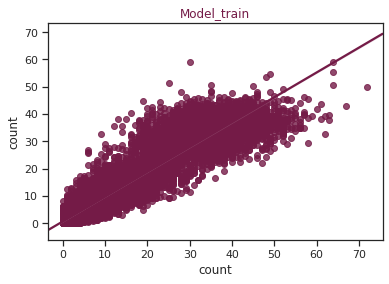

r2 testowy: [0.83 0.85 0.84 0.93 0.7  0.84 0.73 0.58 0.83 0.89 0.35 0.75]


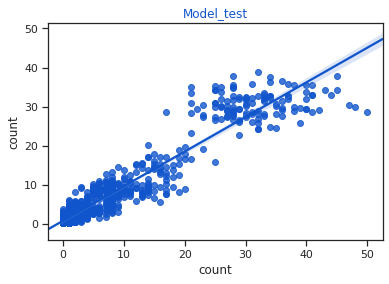

In [27]:
ModVal(Linear_Regression)

<span style="font-size: 160%;background: white;font-weight:bold;color:#1155cc">Zapisujemy wybrany model

In [28]:
import joblib

#RFC = RandomForestClassifier()
#RFC.fit(X_train, y_train) 

filename ='/home/wojciech/Pulpit/6/model_AA.pkl' 

# zapisanie
_ = joblib.dump(model, filename, compress=9)

<span style="font-size: 160%;background: white;font-weight:bold;color:#1155cc">Otwieramy z dysku wybrany model 

In [29]:
# otwarcie z dysku
model_AA = joblib.load(filename) 
model_AA

GridSearchCV(estimator=LinearRegression(),
             param_grid=[{'copy_X': [True, False],
                          'fit_intercept': [True, False],
                          'normalize': [True, False]}])

<span style="font-size: 160%;background: white;font-weight:bold;color:#1155cc">Użycie modelu
    
<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc"> Moge tu otworzyć każde dane i podstawić do modelu pod warunkiem że będą to dane mające strukturę pasującą do modelu - te same kolumny itp.
    
<span style="font-size: 210%;background: white;font-weight:normal;color:#1155cc"> Wybieram sobie notowania z okresu 43-52 tydzień to okres super testowy

In [30]:
SuperTest = df2[df2.Week.isin([43,44,45,46,47,48,49])] 
SuperTest.head(4)

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week
34873,1,43,7,4.0,11.0,7.0,17.0,-7.0,4.0,-10.0,5.0
34874,2,43,4,2.0,5.0,2.0,3.0,-3.0,3.0,-1.0,-4.0
34875,3,43,14,6.0,5.0,3.0,9.0,1.0,2.0,-6.0,-3.0
34876,4,43,10,9.0,6.0,12.0,8.0,3.0,-6.0,4.0,0.0


In [31]:
from sklearn.model_selection import train_test_split 

y = SuperTest['Sales']
X = SuperTest.drop('Sales', axis=1)

#Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.25, random_state = 148)

In [32]:
model = model_AA

model

GridSearchCV(estimator=LinearRegression(),
             param_grid=[{'copy_X': [True, False],
                          'fit_intercept': [True, False],
                          'normalize': [True, False]}])

r2 train: [0.91 0.9  0.89 0.92 0.87 0.91 0.91 0.91 0.9  0.86 0.91 0.87]


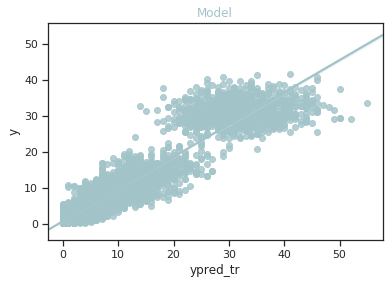

In [33]:
from sklearn.model_selection import cross_val_score 

ypred_tr = model_AA.predict(X)

r2_train = cross_val_score(model_AA,X,y, cv=12)
r2_train = np.round(r2_train, decimals=2)
print('r2 train:', r2_train)

ax = sns.regplot(y,ypred_tr,color='#a2c4c9')
plt.title('Model',color='#a2c4c9') 
plt.ylabel('y', fontsize=12) 
plt.xlabel('ypred_tr', fontsize=12) 
plt.show()

